# Introduction

In this exercise, we are building a naive bayes classifier for tagging documents. The data we use are text documents on 20 topics, consisting of 11293 records for training and 7528 records for testing. The classifier is supposed to learn the conditional probability of what topic a document is about based on which words appear in the training data for the topics. We then use the probability learned from the training data to predict the topic of documents in the testing data.

# Loading and Preprocessing Data

The data are texts delimited by line separators: each line is a document on a topic. The first letter of a document indicates the topic it is on.

In [1]:
import numpy as np
import pandas as pd

We use pd.read_fwf() to save the data into a Pandas Dataframe. Using readlines() may give us more control over how we want to read in the data. However, since our data consists of only text documents, pd.read_fwf() with minimal additional arguments should suffice.

In [2]:
# load train/test data from files
train_file_data = pd.read_fwf("../data/forumTraining.data", header=None, delimiter="\n")
test_file_data = pd.read_fwf("../data/forumTest.data", header=None, delimiter="\n")

We use str.split() to put the first letter of each document into a new column and the rest into a second.

In [3]:
# separate topic from document by adding an extra column
train_data = train_file_data.iloc[:,0].str.split(n=1, expand=True)
test_data = test_file_data.iloc[:,0].str.split(n=1, expand=True)

The documents are already processed: punctuations are all removed and letters converted to lowercase. In addition, we remove stop words--words such as common adverbs (afterwards, everywhere, still, etc.), articles (the/a/an), pronouns (I, we, you, etc.)--from the documents, because they are more functional and convey less meaning, which makes them less useful for our purpose. We also remove words consisting of only 1 or 2 letters, because we can confirm that they do not contribute meaningful concepts to any documents.

In [4]:
# get a list of words consisting of less than 3 letters
# [word for word in set(np.concatenate(train_data[1].str.split())) if len(word) < 3]

The stop words list is obtained from combining lists from three sources: nltk, gensim, and spacy.

In [5]:
from nltk.corpus import stopwords
import gensim
import spacy

# get stop words from three sources (gensim, spacy, nltk)
stopwords_gensim = gensim.parsing.preprocessing.STOPWORDS

sp = spacy.load('en_core_web_sm')
stopwords_spacy = sp.Defaults.stop_words

stopwords_nltk = stopwords.words("english")

# extend the stop words list
stopwords_nltk.extend(['cannot', 'could', 'done', 'let', 'may' 'mayn',  'might',  'must', 'need', 'ought', 'oughtn', 'shall', 'would', 'br', 'faq', 'alt', 'co', 'uk', 'whilst', 'pgp', 'signed', 'he', 'please', 'edu', 'cs', 'umd', 'et', 'al', 'her', 'com', 'like', 'apr'])

# combine the stopwords lists
stop_words = stopwords_gensim.union(set(stopwords_nltk))
stop_words = stop_words.union(set(stopwords_spacy))

def preprocess(df):
    # split words
    filtered_text = df.str.split()

    # filter stopwords
    filtered_text = filtered_text.apply(lambda x: [word for word in x if word not in stop_words])

    # filter words with less than three letters
    filtered_text = filtered_text.apply(lambda x: [word for word in x if len(word) > 2 ])

    return filtered_text

In [6]:
# apply the above text cleaning to both train and test data

train_df = train_data
train_df[1] = preprocess(train_df[1])

test_df = test_data
test_df[1] = preprocess(test_df[1])

We explore the most frequent words for each topic. If we like, we may add frequent words we think are irrelevant to the stop words list.

In [7]:
# group documents by topic
df = train_df.groupby(train_df[0], as_index = False).agg(list)
df[1] = df[1].apply(np.concatenate)

from collections import Counter

# get top frequent words
Counter(df[1][0]).most_common(20)

[('god', 707),
 ('people', 573),
 ('writes', 563),
 ('article', 409),
 ('think', 390),
 ('atheists', 310),
 ('atheism', 301),
 ('know', 275),
 ('believe', 249),
 ('religion', 220),
 ('time', 216),
 ('said', 210),
 ('islam', 203),
 ('evidence', 202),
 ('way', 192),
 ('morality', 192),
 ('keith', 191),
 ('good', 186),
 ('moral', 184),
 ('argument', 184)]

As an option, we may create a word frequency chart for the same purpose as above. For example, the following chart shows the top 20 words in all "atheism" documents.

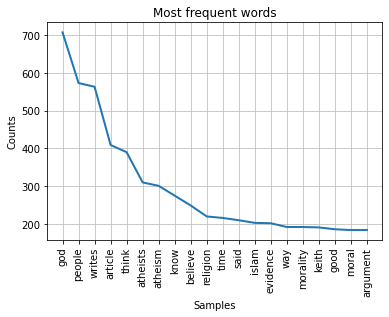

<AxesSubplot:title={'center':'Most frequent words'}, xlabel='Samples', ylabel='Counts'>

In [8]:
from nltk import FreqDist

words_freq = FreqDist(df[1][0])
words_freq.plot(20, title="Most frequent words")

# Model Training

We have the naive bayes model learn word probabilities as specified in the project specification document. we use a set to contain all unique words in all documents. The probabilities of topics (N(documents) of a topic/N(all documents)) are stored in a dictionary named topic_dict. The word probabilities given a particular topic are stored in vocab_dict. We use Laplace smoothing (add 1 to word frequency count) to deal with zero probability. For modularity, a few other relevant variables are returned from the same function.

In [9]:
from collections import Counter
from numba import jit

# @jit()
def train_naive_bayes(df):
    # get vocabulary from all words
    vocabulary = set(np.concatenate(df[1]))

    # get word count to simplify calculation
    total_n_of_vocabulary = len(vocabulary)

    # get topic_count/document_count for all topics
    topic_dict = dict(df.groupby(df[0]).size().div(len(df)))

    # get new df grouped by topic
    new_df = df.groupby(df[0], as_index = False).agg(list)

    # concatenate lists for the same topic from previous grouping
    new_df[1] = new_df[1].apply(np.concatenate)

    # get list of topics
    topic_list = list(set(new_df[0]))

    # get number of word positions for each topic
    word_position = {topic: len(new_df[new_df[0] == topic][1].item()) for topic in topic_list}

    # get the sum of word position and total vocabulary count for each topic
    sum_n_len_vocab = {k: v+total_n_of_vocabulary for k,v in word_position.items()}

    # initialize empty dictionary to store word probabilities in each topic
    vocab_dict = {topic: {} for topic in topic_list}
    for topic in topic_list:
        # initialize a topic with 0 as count values for all words
        vocab_dict[topic] = {word: 0 for word in vocabulary}

        # get index for a topic
        index = new_df[0] == topic

        # count word occurrence
        topic_counter = Counter(new_df[index][1].item())

        # use word count to update dictionary items of the topic
        vocab_dict[topic].update(topic_counter)

        # add 1 to word count to avoid 0 probability, calculate the word probability in a document
        vocab_dict[topic] = {k:(v+1)/sum_n_len_vocab[topic] for k,v in vocab_dict[topic].items()}

    return vocab_dict, vocabulary, topic_dict, topic_list

In [10]:
# train model and get results

training_result = train_naive_bayes(train_df)

vocab_dict, vocabulary, topic_dict, topic_list = training_result[0], training_result[1], training_result[2], training_result[3]

# Model Testing

The fact that probabilities are stored in dictionaries makes retrieving them easy.

In the prediction/classification step, we implement

$$ C_{NB}=\max \limits _{c _{j} \in C}\left(P(c _{j}) \prod \limits_{i \in Positions} 𝑃(a _{i}|c _{j})\right) $$

To deal with underflow (multiplying very small floats), we choose to specify dtype as 'float128', instead of using log. This way we avoid the step of converting probabilities to their log, hoping to improve performance, although the improvement is not that obvious for our data.

In [11]:
@jit()
def predict(df, vocab_dict, vocabulary, topic_dict, topic_list):
    predictions = []
    for row in df.iterrows():
        wordlist = row[1][1]
        preds = []
        for topic in topic_list:
            # put probabilities of found words in np array
            x = np.array([vocab_dict[topic][word] for word in wordlist if word in vocabulary])

            # get the product of the probabilities
            prod_word = np.prod(x, dtype='float128')

            # get the product of topic probability and words probability, add the result to list
            preds.append(np.prod([prod_word, topic_dict[topic]], dtype='float128'))

        # add the topic with the highest probability to prediction
        pred = topic_list[np.argmax(np.array(preds))]
        predictions.append(pred)
    return predictions

In [12]:
# get predictions
def a():
    predictions = predict(test_df, vocab_dict, vocabulary, topic_dict, topic_list)
%timeit a()

AssertionError: 

In [ ]:
result_df = test_df

In [ ]:
# get overall accuracy
accuracy = np.sum(pd.Series(predictions) == result_df[0])/len(result_df)
accuracy

we get 81% overall accuracy using our model on the cleaned data. This is not much different from that of a vanilla sklearn MultinomialNB classifier with little additional processing (79.8% accuracy, as shows below).

# Confusion Matrix

A confusion matrix is a tabulation of prediction vs. actual results, telling us the number of instances our model correctly/incorrectly identifies. We create a confusion matrix using pd.crosstab() and calculate precision and recall using the confusion matrix. Precision tells us the percentage of correct predictions for a class out of all predictions. Recall tells us the percentage correct predictions for a class out of all actual instances of a class.

In [ ]:
def calc_precision(confusion_matrix, topic):
    # the number of correct results divided by the number of all results
    return confusion_matrix[topic][topic]/confusion_matrix[topic][len(confusion_matrix) - 1]

def calc_recall(confusion_matrix, topic):
    # the number of correct results divided by the number of results that should have been returned
    return confusion_matrix[topic][topic]/confusion_matrix.loc[topic][len(confusion_matrix) - 1]

def get_precision_recall(df, pred, topic_list):
    # use crosstab to get confusion matrix
    confusion_matrix = pd.crosstab(df[0], pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    # calculate precision and recall
    precision = [calc_precision(confusion_matrix, topic) for topic in topic_list]
    recall = [calc_recall(confusion_matrix, topic) for topic in topic_list]

    # save the calculation results in a dataframe
    pr_df = pd.DataFrame(zip(topic_list, precision, recall), columns=['topic', 'precision', 'recall'])
    return pr_df

In [ ]:
get_precision_recall(result_df,pd.Series(predictions),topic_list)

# sklearn.MultinomialNB

Here, we use MultinomialNB classifier from sklearn as a benchmark to compare with our naive bayes model above.

In [ ]:
train_data = train_file_data.iloc[:,0].str.split(n=1, expand=True)
test_data = test_file_data.iloc[:,0].str.split(n=1, expand=True)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
mnb = MultinomialNB()

X_train = count_vect.fit_transform(train_data[1])

y_train = np.array(train_data[0])
X_test = count_vect.transform(test_data[1])
y_test = np.array(test_data[0])
clf = MultinomialNB().fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#from sklearn.metrics import confusion_matrix
#conf_mat = confusion_matrix(y_test, y_pred)
#conf_mat

#from sklearn.metrics import precision_recall_fscore_support
#precision_recall_fscore_support(y_test, y_pred, average=None)

# Discussion

Using our model and minimally processed data, we achieved the baseline accuracy of over 79%. Stemming actually decreased overall accuracy, so did removing words consisting of less than 3 letters. However, the difference there was small.

There are groups of topics that are closely related. For example, take a look at the top 10 words for atheism, christianity, and religion.

In [ ]:
atheism_top_10_counter = Counter(df[1][0]).most_common(10)
atheism_top_10 = [k for k,v in atheism_top_10_counter]

christianity_top_10_counter = Counter(df[1][3]).most_common(10)
christianity_top_10 = [k for k,v in christianity_top_10_counter]

religion_top_10_counter = Counter(df[1][17]).most_common(10)
religion_top_10 = [k for k,v in religion_top_10_counter]

pd.DataFrame({'atheism': atheism_top_10, 'christianity': christianity_top_10, 'religion': religion_top_10})

The similarity among the three may account for the low recall we find in religion (0.406375). We also find closeness of this kind in other groups, for instance, politics and mideastpolitics, xwindows and mswindows.

If the classification task is not restricted to the exact 20 topics, we may collapse similar topics into a single topic, and the model performance may improve, since we would have eliminated many correlations.

The model has not been tested on a different dataset, although the most relevant functions are written with modularity in mind.

